In [ ]:
import requests
import json
import time
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#API key
api_key = "RGAPI-a905b251-7935-4d28-9321-85d9d72fdada" #Compte Slylio 
api_key2 = "RGAPI-86be80e4-14ed-49a4-939c-234d3f04d8b7" #Compte emilio
api_key3 = "RGAPI-2671fc10-105b-473e-a9aa-634fa03e20c1" #Compte projetML (username : projetlolML, password : projetlol56)


In [ ]:
#Multi-threading API calls function if bigger dataset needed


In [ ]:
"""_summary_
    This function returns the summonerId of master + ranks players in europe west.
    
    _description_
    This function returns the summonerId of the player by using the API key.
    
    _parameters_
    api_key : str
        The API key that is used to authenticate the request
"""
    
def get_summonerId(api_key):
    challenger_url = 'https://euw1.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5?api_key={}'.format(api_key) # Challanger ENDPOINT
    grandmaster_url = 'https://euw1.api.riotgames.com/lol/league/v4/grandmasterleagues/by-queue/RANKED_SOLO_5x5?api_key={}'.format(api_key) # Grandmaster EDNPOINT
    master_url = 'https://euw1.api.riotgames.com/lol/league/v4/masterleagues/by-queue/RANKED_SOLO_5x5?api_key={}'.format(api_key) # Master ENDPOINT

    league_url_lists = [challenger_url, grandmaster_url, master_url] # Creating a list with the 3 endpoints (master, grandmaster and challenger)

    df_list = [] # A list that will store the response from the get request (league_df)

    for url in league_url_lists: # Loop interation through league_url_lists
        resp = requests.get(url) # Sending a get request to the url
        league_df = pd.json_normalize(resp.json()['entries'])
        df_list.append(league_df)
    
    final_league_df = pd.concat(df_list) # Concatenating the stored information in league_url_lists to create the final_league_df

    return final_league_df

In [ ]:
league_df = get_summonerId(api_key)
print('league_df has information about {} players between master and challenger elo'.format(league_df.shape[0]))

In [ ]:
def get_summonerinfo_by_summonerId(df, api_key):
    
    summoner_list = [] # list that will store the each summoner_info DataFrame

    for i in range(len(df)): # len() get the numbers of rows of the match_ids parameter inserted. Then we use the range() function to create a sequence of number starting from 0 to number returned by len(). 
                            # With that we can interate trough each line in the match_ids dataframe (our function parameter) using the iloc function to get the matchid.

        # Creating a dynamic api_ulr for each register in the summonerId column using iloc
        api_url = 'https://euw1.api.riotgames.com/lol/summoner/v4/summoners/{}?api_key={}'.format(df['summonerId'].iloc[i],api_key)

        # Repeating the process we did at the begining
        resp = requests.get(api_url)
        print(resp.status_code)

        # if, elif and while true to deal with riot api rate limit
        if resp.status_code == 200:
            pass
        elif resp.status_code == 429:
            while True: # while loop because of riot api cost
                if resp.status_code == 429: #429 error is api cost issue
                    print('429 delay try 10 second') #approximate 10 second wait before trying again
                    time.sleep(10)

                    # Trying again
                    api_url = 'https://euw1.api.riotgames.com/lol/summoner/v4/summoners/{}?api_key={}'.format(df['summonerId'].iloc[i],api_key)
                    resp = requests.get(api_url)
                    print(resp.status_code)

                elif resp.status_code == 200:
                    print('limit cost resolve')
                    break

        summoner_info = pd.json_normalize(resp.json()) # The same process we did at the beggining to create the DataFrame
        summoner_list.append(summoner_info) # Appending the DataFrame generated (summoner_info) into the list "summoner_list"
        
    final_summoner_info = pd.concat(summoner_list) # Using pd.concat to concatenate the results stored in the list "summoner_list"
            
    return final_summoner_info
    

In [ ]:
summoner_df = get_summonerinfo_by_summonerId(league_df[:100], api_key)

In [ ]:
summoner_df

In [ ]:
def get_matchids_by_puuid(df, api_key):

    matchids_list = []

    for i in range(len(df)):

        api_url = 'https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?queue=420&type=ranked&start=0&count=50&api_key={}'.format(df['puuid'].iloc[i], api_key)

        resp = requests.get(api_url) # Sending a get request to the api_url
        print(resp.json())

        if resp.status_code == 200:
            matchids = pd.DataFrame(resp.json(), columns=['matchid']) 
            matchids_list.append(matchids) # Appending the DataFrame generated to the list "matchids_list"
        elif resp.status_code == 429:
            while True: # while loop because of riot api cost
                if resp.status_code == 429: #429 error is api cost issue
                    print('429 delay try 100 second') #approximate 110 second wait
                    time.sleep(10)

                    api_url = 'https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?queue=420&type=ranked&start=0&count=50&api_key={}'.format(df['puuid'].iloc[i], api_key)
                    resp = requests.get(api_url)
                    print(resp.status_code)

                    if resp.status_code == 200:
                        matchids = pd.DataFrame(resp.json(), columns=['matchid']) 
                        matchids_list.append(matchids) # Appending the DataFrame generated to the list "matchids_list"
                        print('limit cost resolve')
                        break
                else:
                    break

    matchids_df = pd.concat(matchids_list) # Using pd.concat to concatenate the results stored in the "matchids_list"
    
    return matchids_df


In [ ]:
matchids_df  = get_matchids_by_puuid(summoner_df, api_key)

In [ ]:
#Remove duplicates
size_before = matchids_df.shape[0]
matchids_df = matchids_df.drop_duplicates()
size_after = matchids_df.shape[0]
print('Removed {} duplicates'.format(size_before - size_after))
print('matchids_df has information about {} matches'.format(matchids_df.shape[0]))

In [ ]:
matchids_df.reset_index(inplace=True)
matchids_df.drop(columns = 'index', inplace = True )
matchids_df

In [ ]:
matchids_df.to_csv('matchids.csv', index = False)

In [ ]:
def get_match_info_by_matchId(match_ids, api_key):

    matchid_info_list = [] # List that will store the dataframes generated, for each match id in the for loop 

    for i in range(len(match_ids)):# len() get the numbers of rows of the match_ids parameter inserted. Then we use the range() function to create a sequence of number starting from 0 to number returned by len(). 
                            # With that we can interate trough each line in the match_ids dataframe (our function parameter) using the iloc function to get the matchid.

        api_ulr = 'https://europe.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'.format(match_ids['matchid'].iloc[i], api_key) # here we use the iloc function as explained above to form the api link for each matchid
        resp = requests.get(api_ulr) # Sending a get request to the api_url
        print(resp.status_code) # Printing the status_code of the request

        if resp.status_code == 200: # Here we need to use if statment, because of the riot API rate limit which is 20 requests every 1 sec and 100 requests every 2 minutes. A 200 status_code means that the request was successful so it can move on.
            pass                        
        elif resp.status_code == 429: # A 429 means that we have exceeded the rate limit. To solve that we need to wait and then try again to get a successful request
            while True: # To do taht we use a while true loop, to execute the if, elif statment repeatdly until the status_code is 200. After that we use break statement to come out of this loop.
                if resp.status_code == 429: 
                    print('429 delay try 10 second') #approximate 110 second wait to work
                    time.sleep(10) # Sleep

                    api_url = 'https://europe.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'.format(match_ids['matchid'].iloc[i], api_key) # Trying the request again
                    resp = requests.get(api_url)
                    print(resp.status_code)

                elif resp.status_code == 200:
                    print('limit cost resolve')
                    break        

        # Same process we did in the beginning             
        matchid_info = pd.json_normalize(resp.json()['info']['participants'])
        matchid_info_list.append(matchid_info) # Merging all the dataframes generated and then stored in the matchid_info_list with the concat() function
        
    matchid_info_df = pd.concat(matchid_info_list)

    return matchid_info_df

In [ ]:
matchs_info_df = get_match_info_by_matchId(matchids_df, api_key)

In [ ]:
matchs_info_df
matchs_info_df.to_csv('matchs_info_2900.csv', index = False)


In [2]:
#print(matchs_info_df.columns.tolist())
"""
    Retire les colonnes inutiles (jugé par un expert de league of legends (Emilio))
"""

matchs_info_df = pd.read_csv('matchs_info_2900.csv')
#Move win column to index 1 (for easier debugging)
matchs_info_df = matchs_info_df[['win'] + [col for col in matchs_info_df.columns if col != 'win']]
toRemove = ['championId', 'championName', 'gameEndedInEarlySurrender', 'gameEndedInSurrender', 'inhibitorsLost','item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'nexusKills','nexusLost','nexusTakedowns','participantId','placement','playerAugment1','playerAugment2','playerAugment3','playerAugment4', 'playerScore0', 'playerScore1', 'playerScore3', 'playerScore4', 'playerScore5', 'playerScore6', 'playerScore7', 'playerScore8', 'playerScore9', 'playerScore10', 'playerScore11', 'playerSubteamId', 'profileIcon', 'puuid', 'riotIdGameName', 'riotIdTagline', 'role', 'subteamPlacement', 'summonerName', 'teamEarlySurrendered', 'teamId', 'teamPosition', 'challenges.dancedWithRiftHerald', 'challenges.killsOnRecentlyHealedByAramPack', 'challenges.killsWithHelpFromEpicMonster', 'challenges.lostAnInhibitor', 'challenges.outnumberedNexusKill', 'challenges.poroExplosions', 'challenges.snowballsHit', 'challenges.unseenRecalls','missions.playerScore0','missions.playerScore1','missions.playerScore2','missions.playerScore3','missions.playerScore4','missions.playerScore5','missions.playerScore6','missions.playerScore7','missions.playerScore8','missions.playerScore9','missions.playerScore10','missions.playerScore11', 'perks.statPerks.defense', 'perks.statPerks.flex', 'perks.statPerks.offense', 'perks.styles', 'challenges.teleportTakedowns', 'challenges.highestCrowdControlScore', 'challenges.earliestBaron', 'eligibleForProgression', 'gameEndedInEarlySurrender', 'lane', 'largestCriticalStrike', 'nexusKills', 'nexusLost', 'nexusTakedowns','individualPosition', 'summonerId','challenges.legendaryItemUsed','challenges.moreEnemyJungleThanOpponent', 'challenges.legendaryItemUsed', 'summonerId', 'individualPosition']
matchs_info_df_non_filtre = matchs_info_df
print(matchs_info_df_non_filtre.columns)


NameError: name 'pd' is not defined

In [ ]:
matchs_info_df = matchs_info_df.drop(columns=toRemove, axis=1, inplace=False)
print(matchs_info_df.columns)


In [ ]:
#
matchs_info_test = matchs_info_df.groupby(np.arange(len(matchs_info_df))//5).sum()
pd.set_option('display.max_columns', None)

matchs_info_test

In [ ]:
#On récupère les deux équipes pour pouvoir les mettre sur la même ligne et avoir une ligne = un match
equipes_1 = matchs_info_test.iloc[::2]
equipes_1.reset_index(inplace=True)
equipes_1.drop(columns = 'index', inplace = True)

equipes_2 = matchs_info_test.iloc[1::2]
equipes_2.reset_index(inplace=True)
equipes_2.drop(columns = 'index', inplace = True)



In [ ]:
equipes_1

In [ ]:
equipes_2

In [ ]:
#Concat columns of equipes_1 and equipes_2 with _0 et _1 suffix
matchs_dataset = pd.concat([equipes_1.add_suffix('_0'), equipes_2.add_suffix('_1')], axis=1) 


In [ ]:
matchs_dataset
#TO DO ONE TIME bcs columns are already renamed or dropped
wins = matchs_dataset['win_0']/5
matchs_dataset['win_0'] = wins
matchs_dataset.drop(columns='win_1', inplace=True)
matchs_dataset.rename(columns = {'win_0':'win'}, inplace = True)



In [ ]:
matchs_dataset.drop_duplicates(inplace=True)

In [ ]:
matchs_dataset

In [ ]:
matchs_dataset.to_csv('matchs_dataset.csv', index = False)

# Visualisation du dataset

In [3]:
import requests
import json
import time
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle


In [4]:
data = pd.read_csv('matchs_dataset_1.csv')
#data = shuffle(data)
target = data['win']
#data.drop(columns = 'win', inplace = True)

In [5]:
from sklearn.decomposition import PCA
#Try to reduce the number of features with PCA
pca = PCA(n_components=0.95, svd_solver='full')
pca.fit(data)
X_pca = pca.fit_transform(data)
data_pca = data_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])



In [ ]:
data_pca

In [6]:
target

0       1.0
1       1.0
2       0.0
3       0.0
4       1.0
       ... 
3838    0.0
3839    0.0
3840    1.0
3841    0.0
3842    0.0
Name: win, Length: 3843, dtype: float64

In [7]:
data_to_display = data[data.columns[:len(data.columns)//2]] #For histogram display, we dont want to display red team stats
data_sample = data.sample(2000) #Sample 2000 rows to work with
data_to_display

,win,allInPings_0,assistMePings_0,assists_0,baronKills_0,basicPings_0,bountyLevel_0,champExperience_0,champLevel_0,championTransform_0,...,challenges.killsOnLanersEarlyJungleAsJungler_0,challenges.fastestLegendary_0,challenges.firstTurretKilledTime_0,challenges.soloTurretsLategame_0,challenges.highestChampionDamage_0,challenges.highestWardKills_0,challenges.thirdInhibitorDestroyedTime_0,challenges.shortestTimeToAceFromFirstTakedown_0,challenges.fasterSupportQuestCompletion_0,challenges.earliestElderDragon_0
0,1.0,10,52,53,2,0,16,76252,78,0,...,0.0,1713.098658,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,1.0,4,7,74,1,0,9,72084,77,2,...,3.0,0.000000,3875.332088,0.0,1.0,0.0,7841.599718,0.000000,0.0,0.0
2,0.0,0,28,23,0,0,0,44885,59,0,...,1.0,0.000000,0.000000,2.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.0,1,4,15,0,0,1,51233,64,0,...,1.0,0.000000,0.000000,2.0,0.0,1.0,0.000000,0.000000,0.0,0.0
4,1.0,13,51,54,1,0,1,73516,77,0,...,3.0,1788.463196,0.000000,0.0,1.0,1.0,0.000000,79.431437,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3838,0.0,0,37,66,1,0,1,74780,78,0,...,1.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0
3839,0.0,6,32,53,0,0,0,70681,75,0,...,2.0,0.000000,0.000000,1.0,1.0,0.0,0.000000,137.264005,1.0,0.0
3840,1.0,6,48,53,1,0,10,75051,78,0,...,1.0,0.000000,3251.483967,4.0,1.0,1.0,0.000000,75.469309,0.0,0.0
3841,0.0,5,8,16,0,0,0,49733,63,0,...,1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0


# Histogrammes 

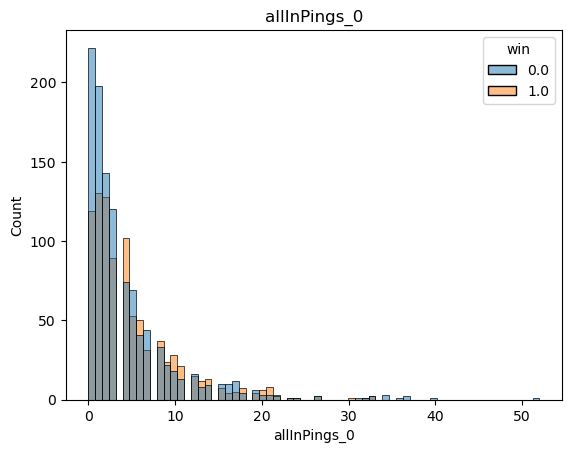

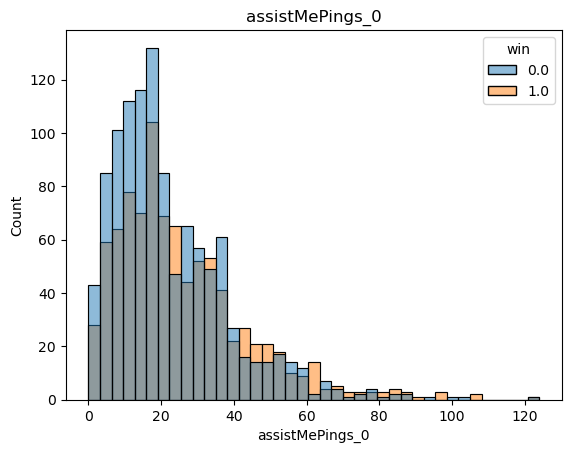

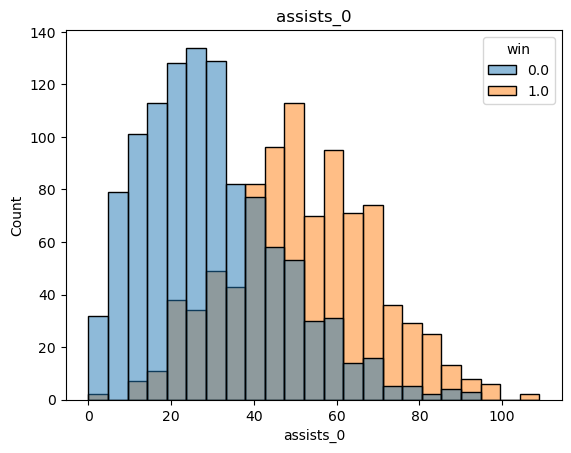

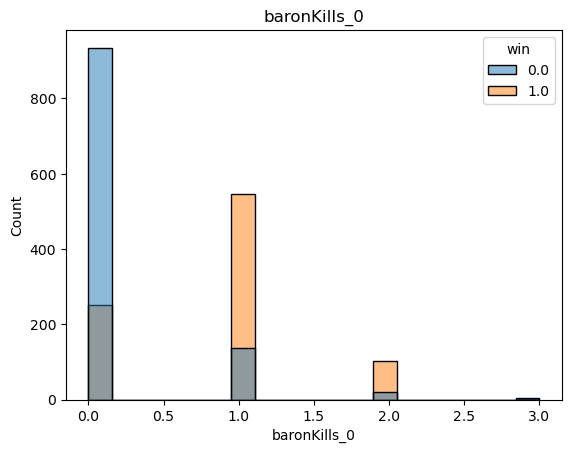

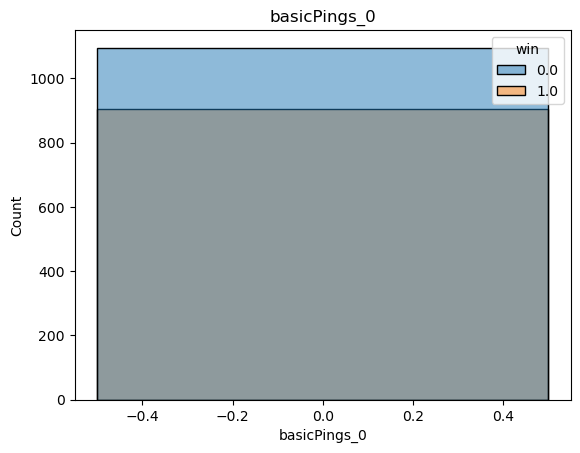

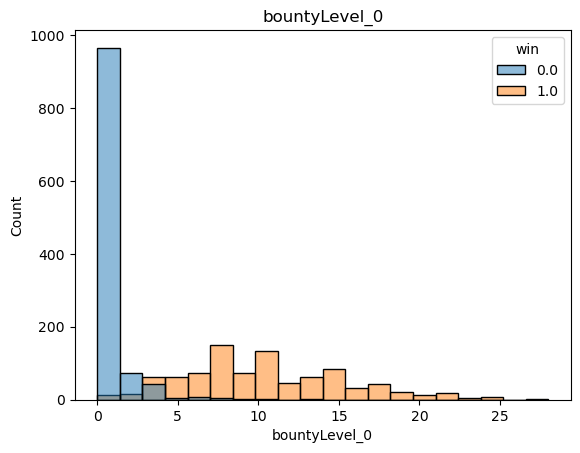

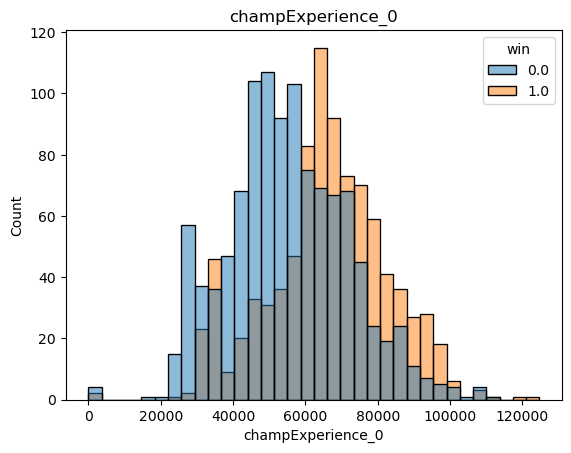

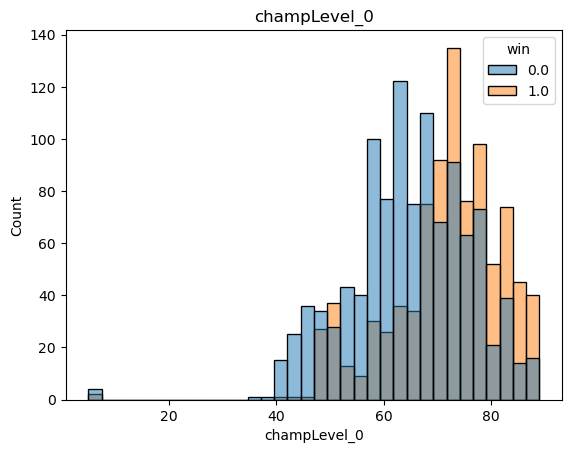

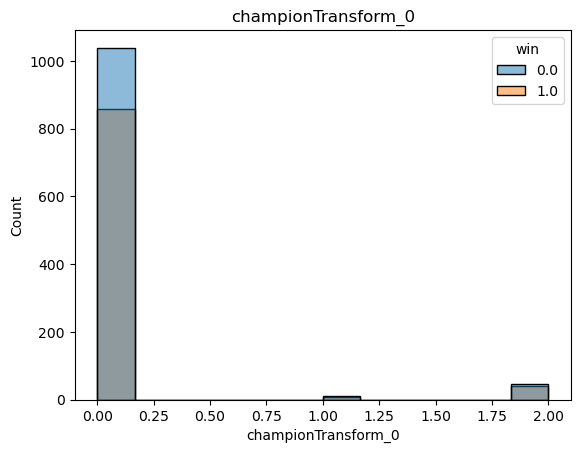

In [9]:
#We take the first half of the dataset to display variables distribution with seaborn
#display the distribution of the variables

plt.figsize=(20,20)
for col in data_to_display.columns[1:10]: #We display from column 1 to 10
    sns.histplot(data_sample, x=col, hue=target)
    plt.title(col)
    plt.show()

In [77]:
data_to_display.describe()

,win,allInPings_0,assistMePings_0,assists_0,baronKills_0,basicPings_0,bountyLevel_0,champExperience_0,champLevel_0,championTransform_0,...,challenges.killsOnLanersEarlyJungleAsJungler_0,challenges.fastestLegendary_0,challenges.firstTurretKilledTime_0,challenges.soloTurretsLategame_0,challenges.highestChampionDamage_0,challenges.highestWardKills_0,challenges.thirdInhibitorDestroyedTime_0,challenges.shortestTimeToAceFromFirstTakedown_0,challenges.fasterSupportQuestCompletion_0,challenges.earliestElderDragon_0
count,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.0,3843.000000,3843.000000,3843.000000,3843.000000,...,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.00000,3843.000000
mean,0.449649,4.594067,24.534999,40.069737,0.480094,0.0,4.900859,60266.040333,68.037731,0.098361,...,1.358834,305.562187,1864.116428,1.021858,0.456935,0.583138,432.652489,24.567163,0.24330,89.795316
std,0.497523,5.829986,17.831737,20.668307,0.634187,0.0,5.906816,17925.609806,11.752806,0.424037,...,1.265216,625.266087,2021.383312,1.086829,0.498207,0.572715,1878.250240,46.685068,0.42913,957.453385
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,5.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,1.000000,12.000000,24.000000,0.000000,0.0,0.000000,47991.500000,61.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,3.000000,20.000000,38.000000,0.000000,0.0,2.000000,60638.000000,69.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
75%,1.000000,6.000000,33.000000,55.000000,1.000000,0.0,9.000000,71865.000000,76.000000,0.000000,...,2.000000,0.000000,4006.667731,2.000000,1.000000,1.000000,0.000000,32.214294,0.00000,0.000000
max,1.000000,76.000000,173.000000,114.000000,3.000000,0.0,28.000000,136150.000000,90.000000,2.000000,...,9.000000,3927.783002,5529.415284,6.000000,1.000000,3.000000,13056.566693,269.033200,1.00000,13241.609871


# Graphs

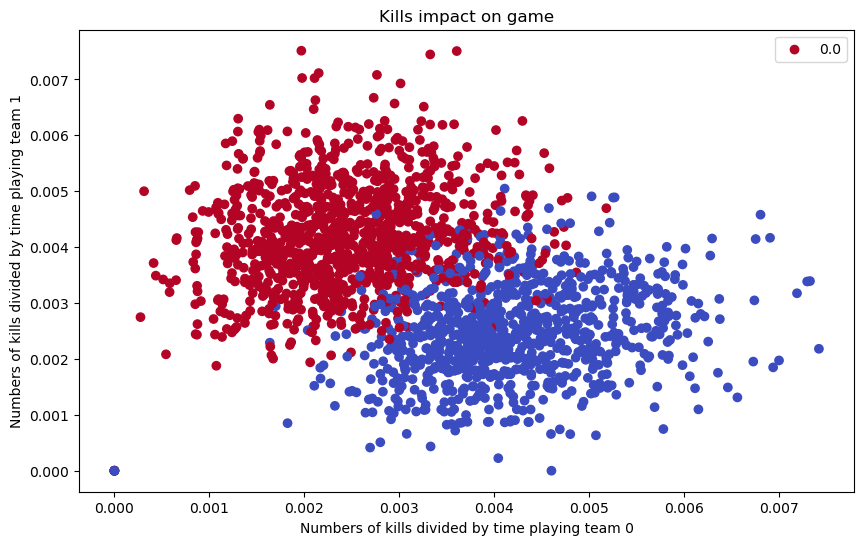

In [57]:
plt.figure(figsize=(10,6))
plt.title('Kills impact on game')
plt.scatter(data_sample['kills_0']/data_sample["timePlayed_0"], data_sample['kills_1']/data_sample["timePlayed_1"], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of kills divided by time playing team 0')
plt.ylabel('Numbers of kills divided by time playing team 1')
plt.legend(data_sample['win']) 
plt.show()

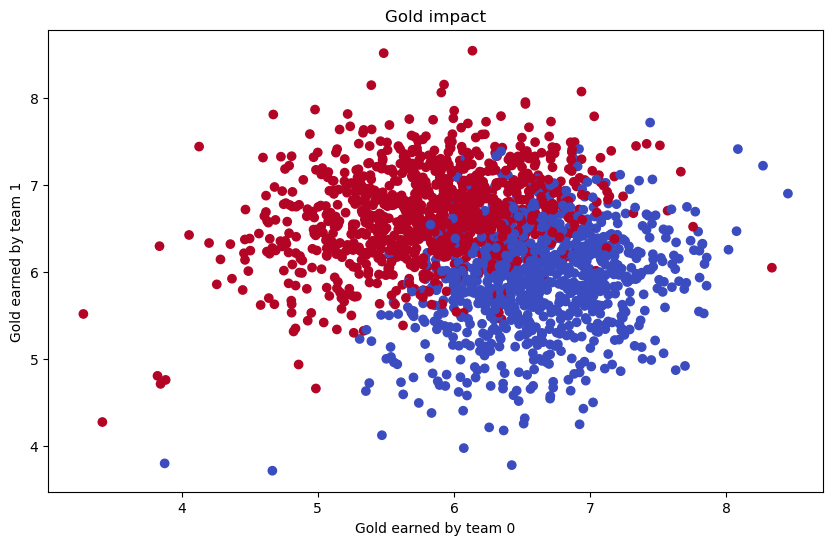

In [58]:
#Impact of golds spent on the game normalized by time played in
plt.figure(figsize=(10,6))
plt.title('Gold impact')
plt.scatter(data_sample["goldSpent_0"]/data_sample["timePlayed_0"],data_sample['goldSpent_1']/data_sample["timePlayed_1"] , c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Gold earned by team 0')
plt.ylabel('Gold earned by team 1')
plt.show()

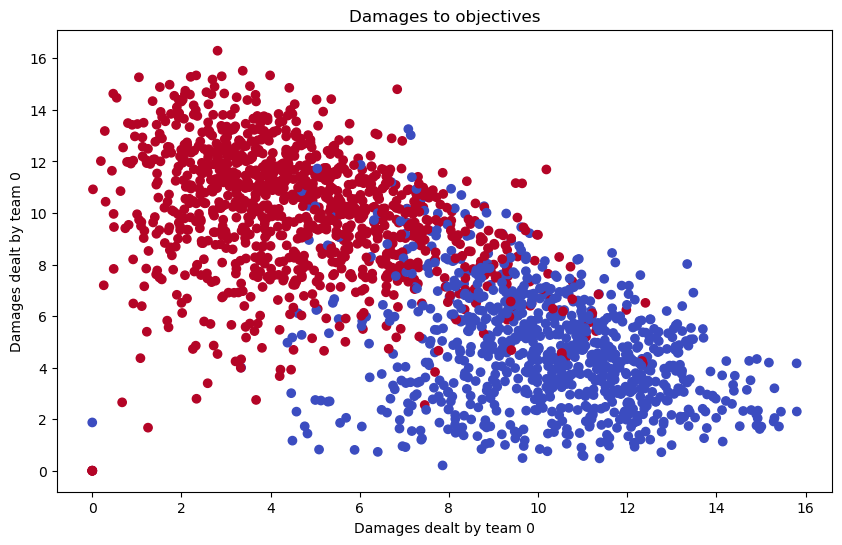

In [59]:
#Damages to objectives and its impact on game
plt.figure(figsize=(10,6))
plt.title('Damages to objectives')
plt.scatter(data_sample['damageDealtToObjectives_0']/data_sample['timePlayed_0'], data_sample['damageDealtToObjectives_1']/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Damages dealt by team 0')
plt.ylabel('Damages dealt by team 0')
plt.show()

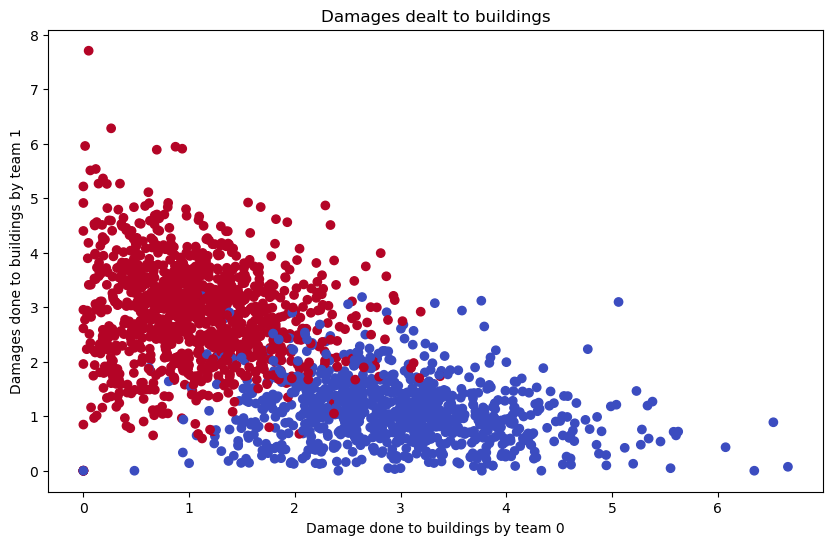

In [60]:
#Damages to buildings by teams and its impact on the game
plt.figure(figsize=(10,6))
plt.title("Damages dealt to buildings")
plt.scatter(data_sample['damageDealtToBuildings_0']/data_sample['timePlayed_0'], data_sample['damageDealtToBuildings_1']/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Damage done to buildings by team 0')
plt.ylabel('Damages done to buildings by team 1')
plt.show()

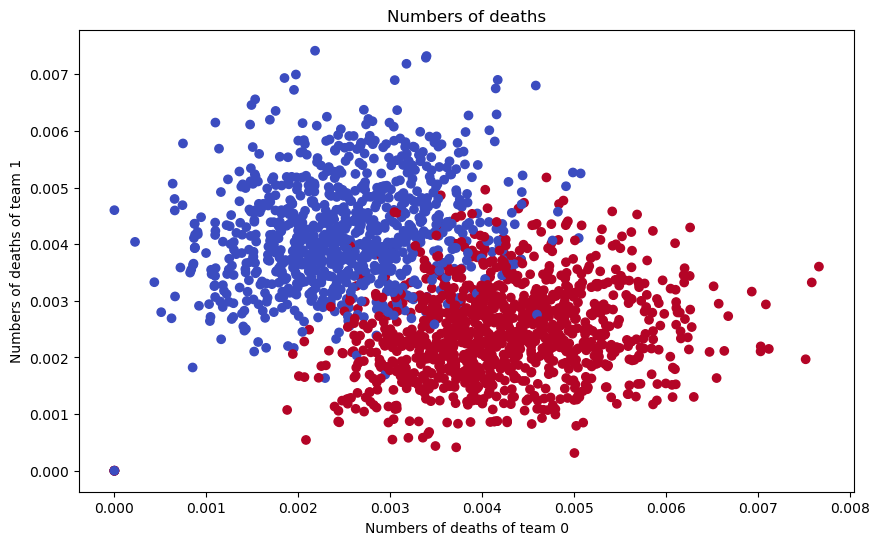

In [61]:
#Numbers of deaths and its impact on the game
plt.figure(figsize=(10,6))
plt.title("Numbers of deaths")
plt.scatter(data_sample['deaths_0']/data_sample['timePlayed_0'], data_sample['deaths_1']/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of deaths of team 0')
plt.ylabel('Numbers of deaths of team 1')
plt.show()

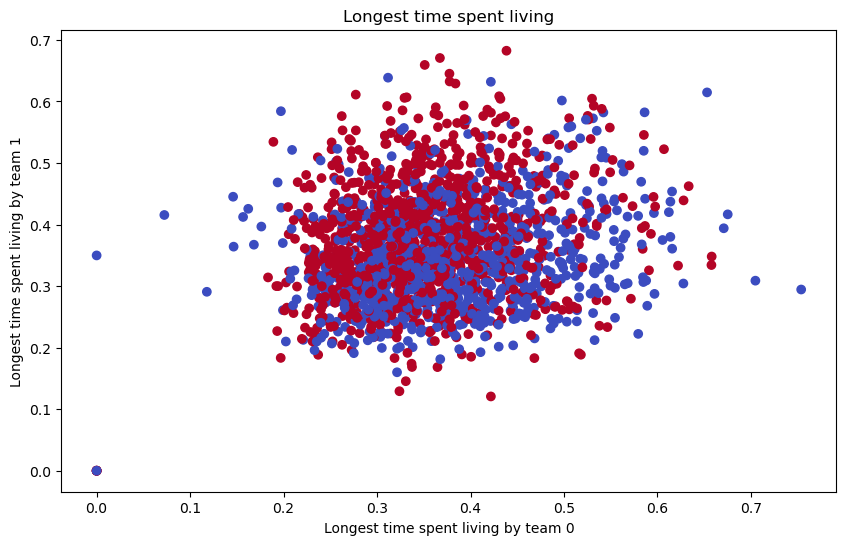

In [62]:
#Longest time alive of a team and its impact on the game
plt.figure(figsize=(10,6))
plt.title('Longest time spent living')
plt.scatter(data_sample['longestTimeSpentLiving_0']/data_sample['timePlayed_0'], data_sample['longestTimeSpentLiving_1']/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Longest time spent living by team 0')
plt.ylabel('Longest time spent living by team 1')
plt.show()

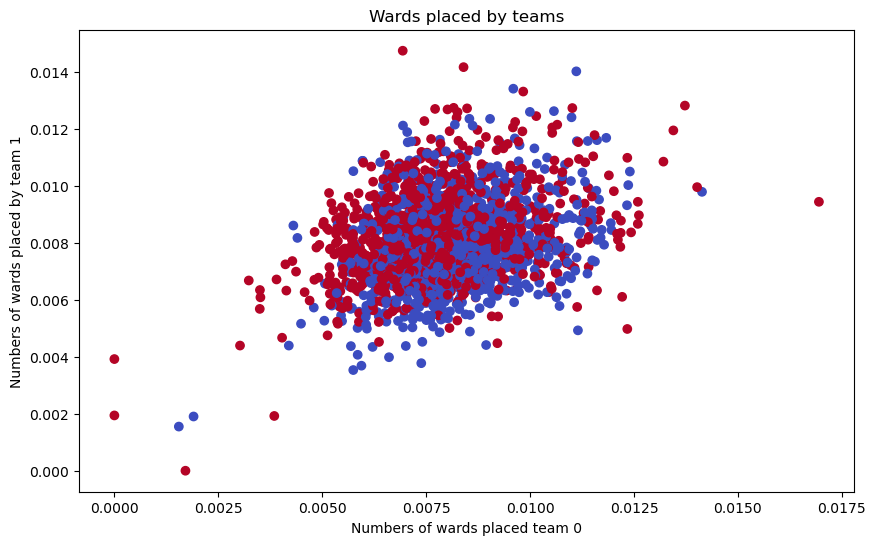

In [63]:
#Wards placed by teams
plt.figure(figsize=(10,6))
plt.title('Wards placed by teams')
plt.scatter(data_sample['wardsPlaced_0']/data_sample['timePlayed_0'], data_sample['wardsPlaced_1']/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of wards placed team 0')
plt.ylabel('Numbers of wards placed by team 1')
plt.show()

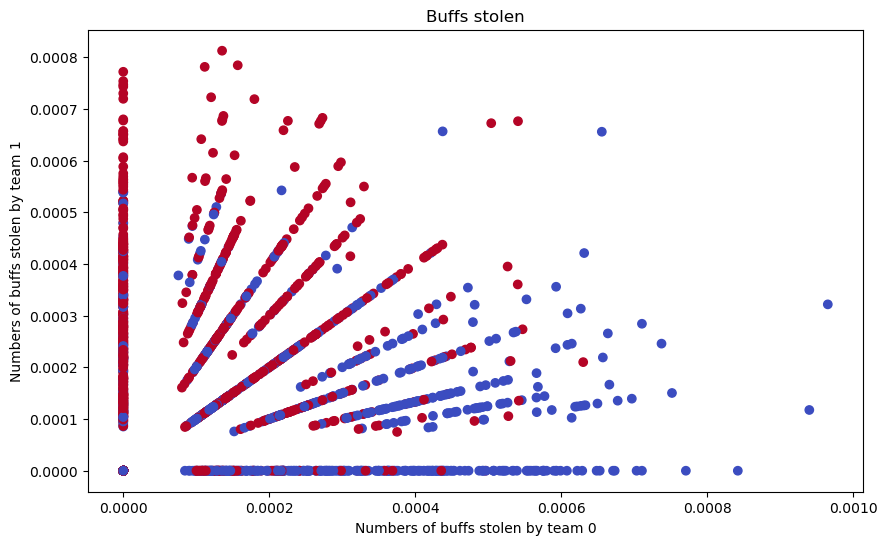

In [64]:
#Bonus buffs stolen in ennemy team
plt.figure(figsize=(10,6))
plt.title('Buffs stolen')
plt.scatter(data_sample["challenges.buffsStolen_0"]/data_sample['timePlayed_0'], data_sample["challenges.buffsStolen_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of buffs stolen by team 0')
plt.ylabel('Numbers of buffs stolen by team 1')
plt.show()

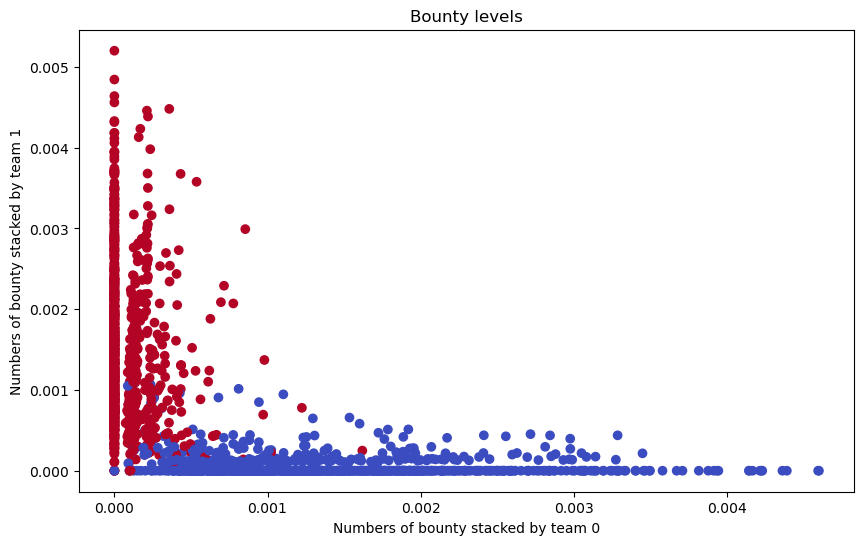

In [65]:
#Wards placed by teams and its impact on the game
plt.figure(figsize=(10,6))
plt.title('Bounty levels')
plt.scatter(data_sample["bountyLevel_0"]/data_sample['timePlayed_0'], data_sample["bountyLevel_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of bounty stacked by team 0')
plt.ylabel('Numbers of bounty stacked by team 1')
plt.show()

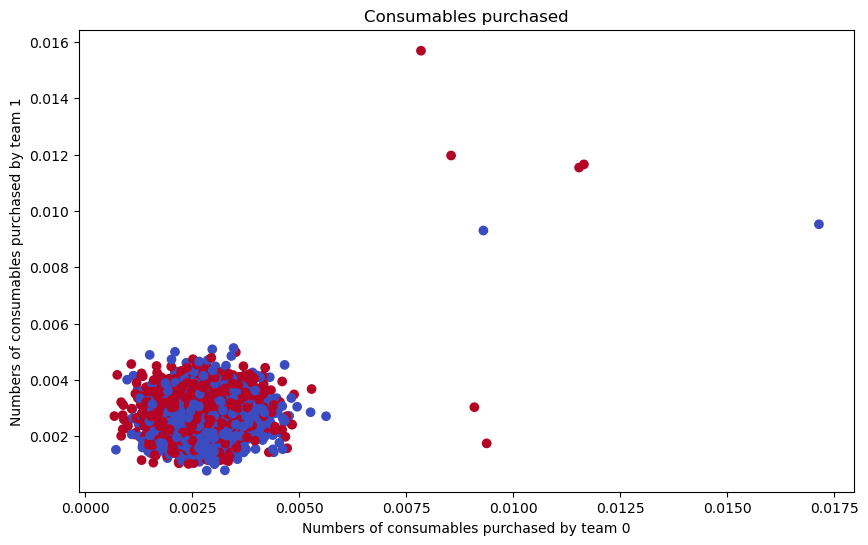

In [66]:
#ZOOM DESSUS
plt.figure(figsize=(10,6))
plt.title('Consumables purchased')
plt.scatter(data_sample["consumablesPurchased_0"]/data_sample['timePlayed_0'], data_sample["consumablesPurchased_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of consumables purchased by team 0')
plt.ylabel('Numbers of consumables purchased by team 1')
plt.show()

ENLEVE LES GQMES QVEC TIME UNDER 10 mins
FIGURE OUT HOW TO enleve outliers


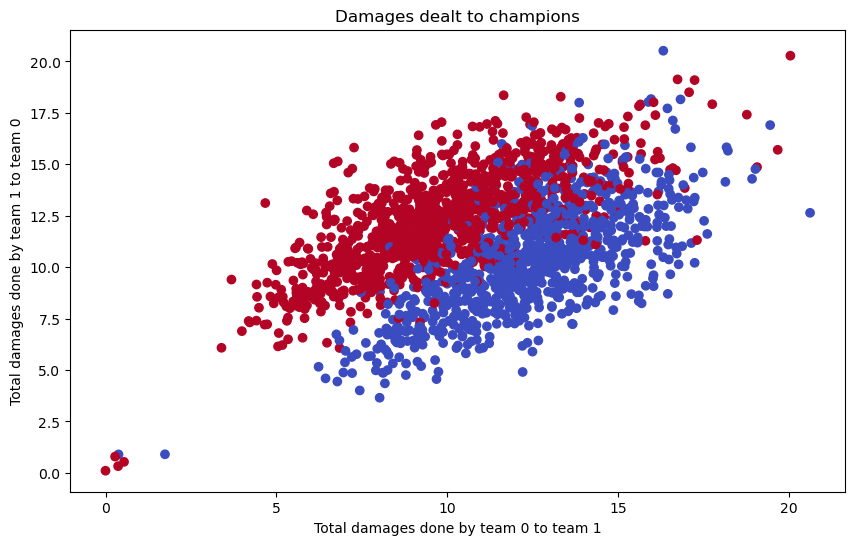

In [67]:
plt.figure(figsize=(10,6))
plt.title("Damages dealt to champions")
plt.scatter(data_sample["totalDamageDealtToChampions_0"]/data_sample['timePlayed_0'], data_sample["totalDamageDealtToChampions_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Total damages done by team 0 to team 1')
plt.ylabel('Total damages done by team 1 to team 0')
plt.show()

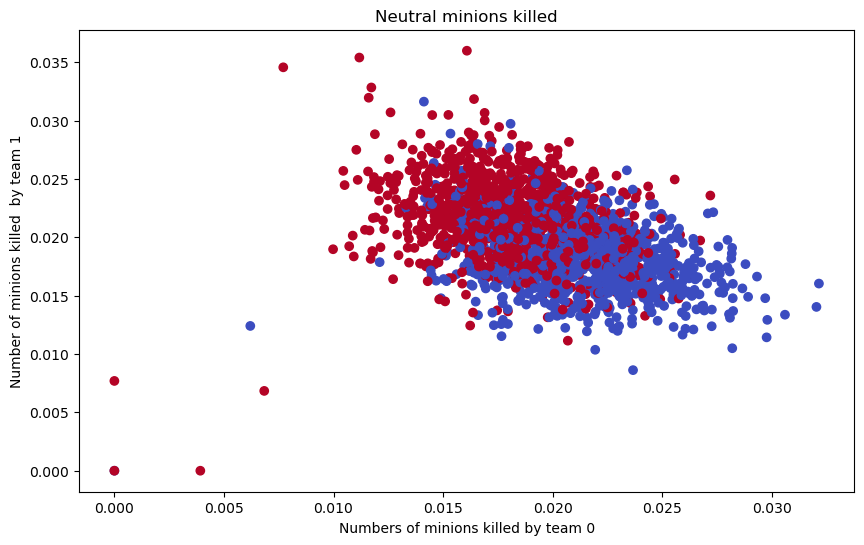

In [68]:
plt.figure(figsize=(10,6))
plt.title('Neutral minions killed')
plt.scatter(data_sample["neutralMinionsKilled_0"]/data_sample['timePlayed_0'], data_sample["neutralMinionsKilled_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of minions killed by team 0')
plt.ylabel('Number of minions killed  by team 1')
plt.show()

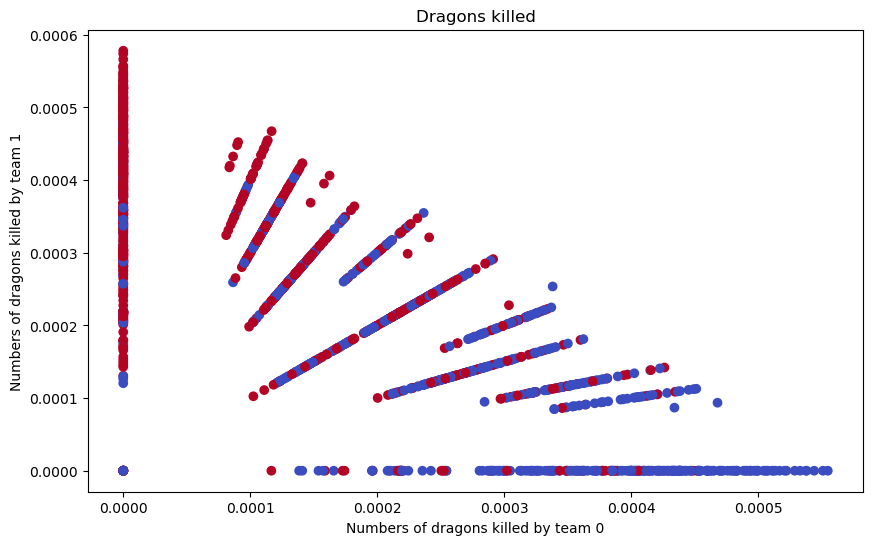

In [69]:
plt.figure(figsize=(10,6))
plt.title('Dragons killed')
plt.scatter(data_sample["dragonKills_0"]/data_sample['timePlayed_0'], data_sample["dragonKills_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of dragons killed by team 0')
plt.ylabel('Numbers of dragons killed by team 1')
plt.show()

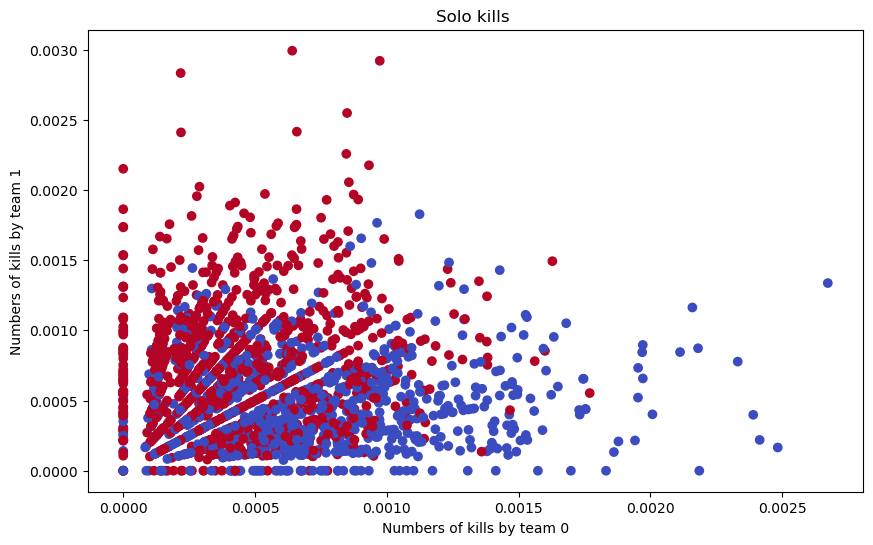

In [70]:
plt.figure(figsize=(10,6))
plt.title('Solo kills ')
plt.scatter(data_sample["challenges.soloKills_0"]/data_sample['timePlayed_0'], data_sample["challenges.soloKills_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of kills by team 0')
plt.ylabel('Numbers of kills by team 1')
plt.show()

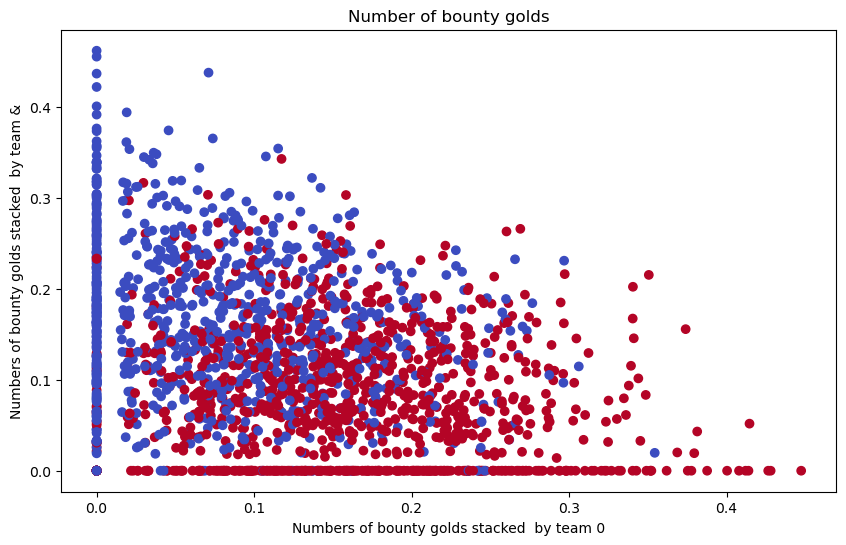

In [71]:
plt.figure(figsize=(10,6))
plt.title('Number of bounty golds')
plt.scatter(data_sample["challenges.bountyGold_0"]/data_sample['timePlayed_0'], data_sample["challenges.bountyGold_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of bounty golds stacked  by team 0')
plt.ylabel('Numbers of bounty golds stacked  by team &')
plt.show()

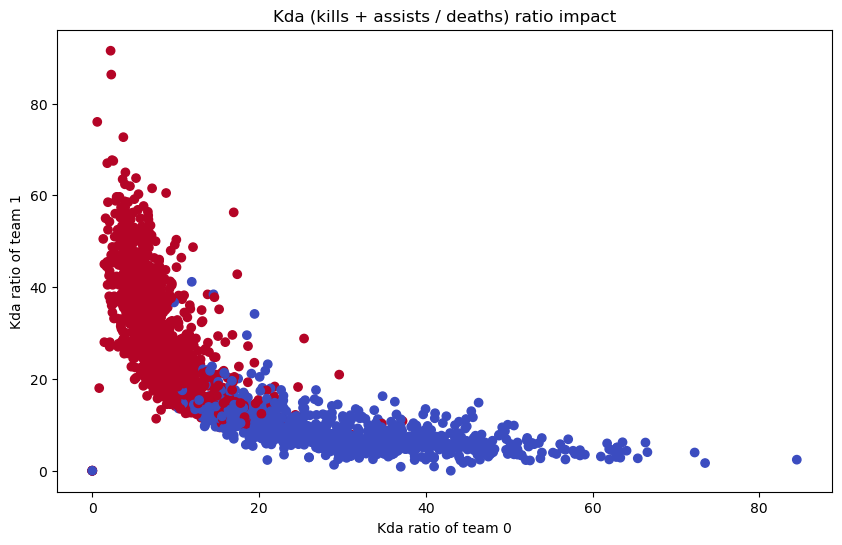

In [73]:
plt.figure(figsize=(10,6))
plt.title('Kda (kills + assists / deaths) ratio impact')
plt.scatter(data_sample["challenges.kda_0"], data_sample["challenges.kda_1"], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Kda ratio of team 0')
plt.ylabel('Kda ratio of team 1')
plt.show()

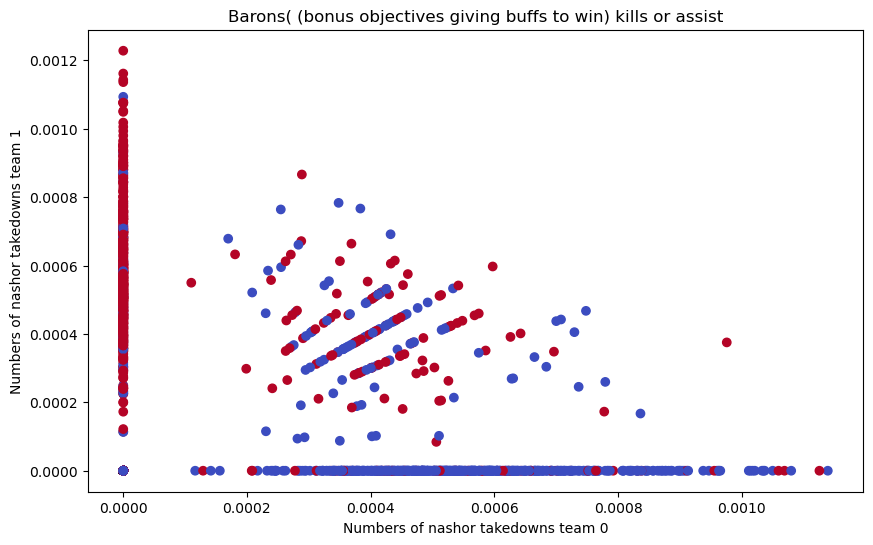

In [74]:
plt.figure(figsize=(10,6))
plt.title('Barons( (bonus objectives giving buffs to win) kills or assist')
plt.scatter(data_sample["challenges.baronTakedowns_0"]/data_sample['timePlayed_0'], data_sample["challenges.baronTakedowns_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of nashor takedowns team 0')
plt.ylabel('Numbers of nashor takedowns team 1')
plt.show()

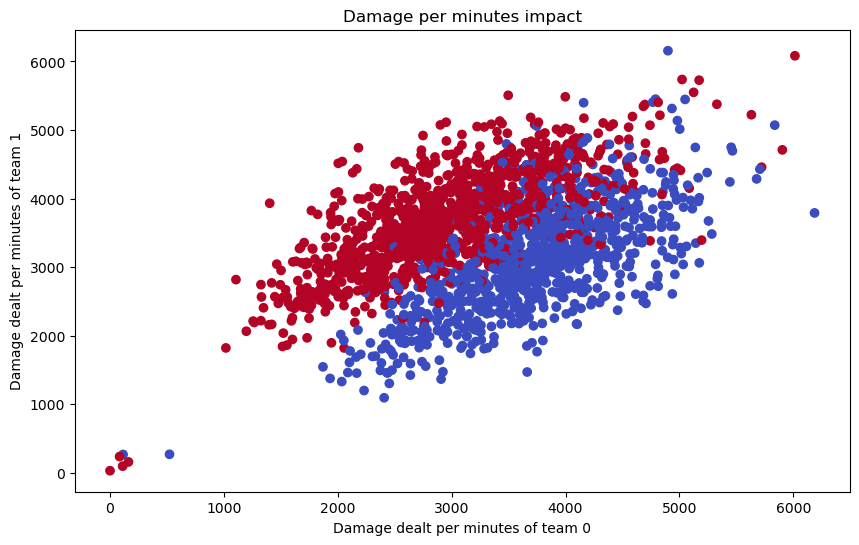

In [76]:
plt.figure(figsize=(10,6))
plt.title('Damage per minutes impact')
plt.scatter(data_sample["challenges.damagePerMinute_0"], data_sample["challenges.damagePerMinute_1"], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Damage dealt per minutes of team 0')
plt.ylabel('Damage dealt per minutes of team 1')
plt.show()

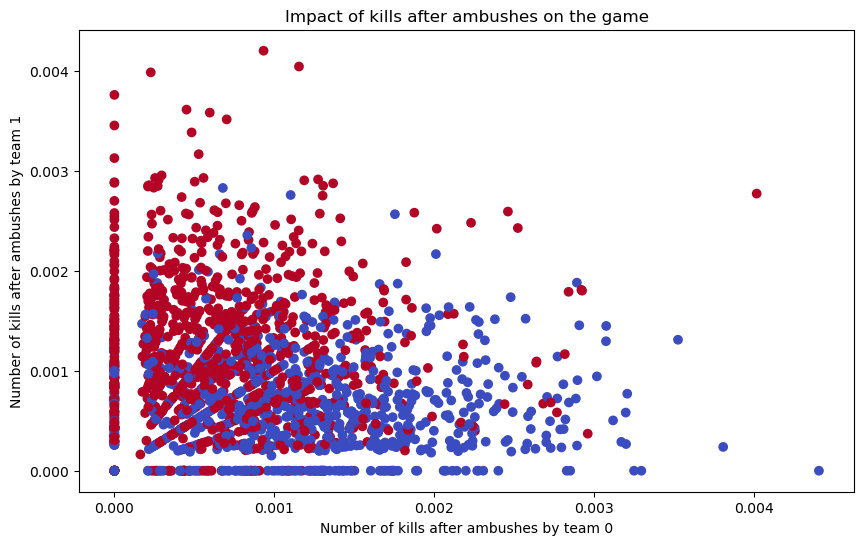

In [78]:
plt.figure(figsize=(10,6))
plt.title('Impact of kills after ambushes on the game')
plt.scatter(data_sample["challenges.killAfterHiddenWithAlly_0"]/data_sample['timePlayed_0'], data_sample["challenges.killAfterHiddenWithAlly_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Number of kills after ambushes by team 0')
plt.ylabel('Number of kills after ambushes by team 1')
plt.show()

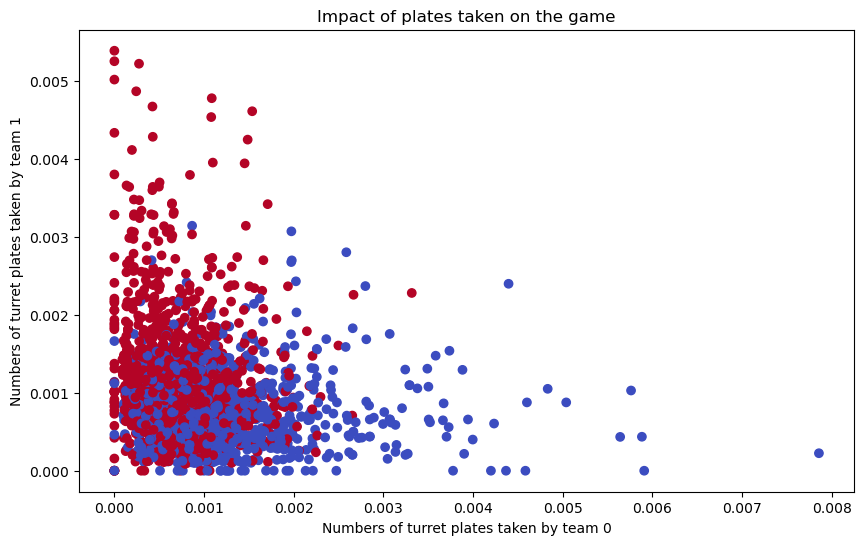

In [79]:
plt.figure(figsize=(10,6))
plt.title('Impact of plates taken on the game')
plt.scatter(data_sample["challenges.turretPlatesTaken_0"]/data_sample['timePlayed_0'], data_sample["challenges.turretPlatesTaken_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of turret plates taken by team 0')
plt.ylabel('Numbers of turret plates taken by team 1')
plt.show()